# Resolviendo tareas usando Machine Learning

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y nos pide evaluar esa posibilidad.

Para ello realizaremos un modelo de ML para podre resolver las siguientes tareas:

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.

**Tabla de contenido:**

1. Inicialización
2. Carga de datos
3. Análisis exploratorio de datos
4. Tarea 1: Clientes similares
5. Tarea 2: ¿Es probable que un cliente reciba una prestación del seguro?
6. Tarea 3: Cantidad de seguros que recibirá un nuevo cliente
7. Tarea 4: Ofuscar datos
8. Conclusiones

**Objetivos**

1. Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
2. Predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
3. Predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
4. Proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior


Descripción de los datasets del proyecto:

- `gender`: género del cliente
- `age`: edad del cliente
- `income`: ingresos del cliente
- `family_members`: cantidad de miembros de familia
- `insurance_benefits`: cantidad de beneficios del seguro

# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
# Instalar actualización de scikit-learn
%pip install scikit-learn --upgrade

  Using cached scikit_learn-1.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar librerías necesarias
import math
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Carga de datos

Ahora procederemos a cargar los datos y hacer una revsión previa de ellos.

In [3]:
# Cargar data
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
# Crear función para renombrar columnas
def to_snake_case(name):
    name = name.replace(' ', '_')
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Renombrar columnas
df.columns = [to_snake_case(col) for col in df.columns]
df = df.rename(columns={'salary': 'income'})
df.head(1)

,gender,age,income,family_members,insurance_benefits
0,1,41.0,49600.0,1,0


In [5]:
# Ver sample de data
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1945,1,31.0,36600.0,3,0
1221,0,31.0,49900.0,1,0
4854,1,22.0,30300.0,1,0
2284,0,43.0,53200.0,1,1
2965,0,44.0,46300.0,0,1
2119,1,24.0,44200.0,1,0
730,0,44.0,48400.0,0,1
4524,0,18.0,36900.0,1,0
1249,1,41.0,36000.0,3,0
1749,1,48.0,46700.0,2,1


In [6]:
# Ver detalles de la tabla
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# Cambiar 'age' a tipo entero
df['age'] = df['age'].astype('int')

In [8]:
# Comprobar conversión
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# Verificar estadísticas descriptivas
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Al parecer nuestra data no tiene ningún problema hasta el momento.

## Análisis exploratorio de datos

Ahora veremos como se está ditribuyendo nuestros datos por cada columna de esta usando gráficos de caja.

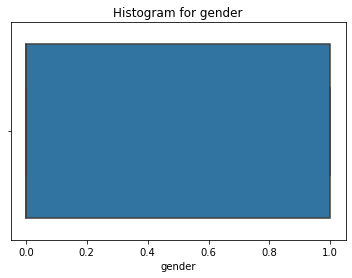

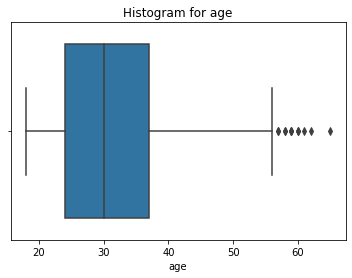

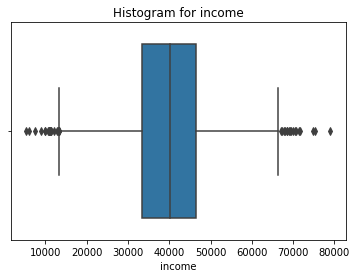

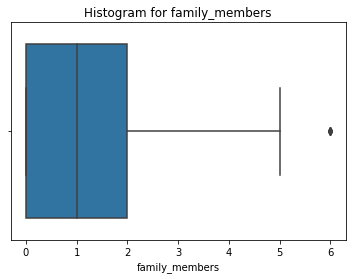

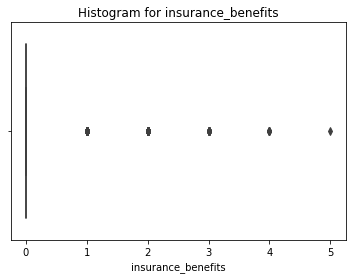

In [10]:
# Analizar la distribución de la data por columna
for column in df.columns:
    plt.figure()
    sns.boxplot(data=df, x=column)
    plt.title(f'Histogram for {column}')
    plt.show()    

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

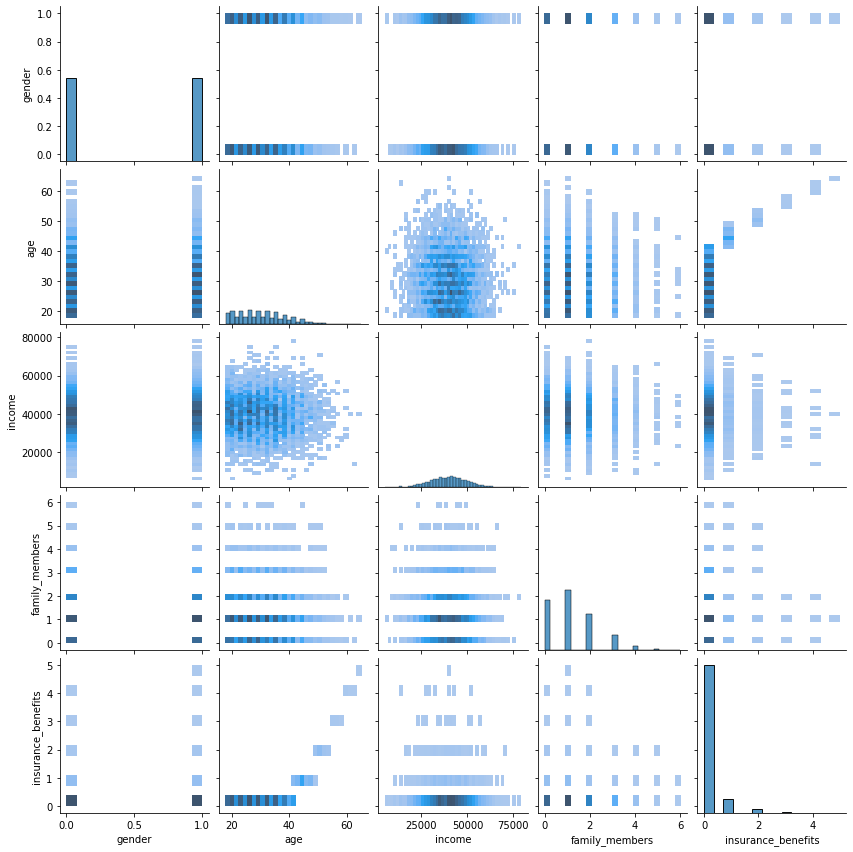

In [11]:
# Graficar gráfico de pares
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

## Tarea 1: Clientes similares

Para resolver la primera tarea desarrollaremos un modelo que devuleva los k vecinos más cercanos para un objeto dado basándose en la distancia entre los estos. 

En nuestro caso, estos objetos serían clientes y el modelo que usaremos será NearestNeighbors. Usaremos dos tipos de distancia: Euclidiana y Manhattan. 

Por último, comprobaremos nuestros resultados escalando nuestros datos versus los datos originales.

In [12]:
# Establecer features
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
# Crear función para obtener los clientes más cercanos
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(metric = metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [14]:
# Comprobar función utilizando método Euclidiana
df_euclidean_no_escalated = get_knn(df, 240, 10, 'euclidean')
df_euclidean_no_escalated

,gender,age,income,family_members,insurance_benefits,distance
240,1,31,41500.0,0,0,0.000000
3693,1,30,41500.0,1,0,1.414214
548,1,33,41500.0,0,0,2.000000
1928,0,33,41500.0,1,0,2.449490
747,0,33,41500.0,1,0,2.449490
4534,0,34,41500.0,0,0,3.162278
3280,0,34,41500.0,1,0,3.316625
3961,0,28,41500.0,1,0,3.316625
2389,1,34,41500.0,2,0,3.605551
4982,1,29,41500.0,3,0,3.605551


In [15]:
# Comprobar función utilizando método Manhattan
df_manhattan_no_escalated = get_knn(df, 240, 10, 'manhattan')
df_manhattan_no_escalated

,gender,age,income,family_members,insurance_benefits,distance
240,1,31,41500.0,0,0,0.0
3693,1,30,41500.0,1,0,2.0
548,1,33,41500.0,0,0,2.0
1928,0,33,41500.0,1,0,4.0
4534,0,34,41500.0,0,0,4.0
747,0,33,41500.0,1,0,4.0
3279,0,27,41500.0,0,0,5.0
4982,1,29,41500.0,3,0,5.0
3961,0,28,41500.0,1,0,5.0
2389,1,34,41500.0,2,0,5.0


Se observa que los resultados en cuanto a los objetos similares son los mismos utilizando ambos métodos. Sin embargo, la distancia calculada por la métrica Manhattan no es tan exacta lo que causa que de valores de distancia iguales para diferentes objetos. Ello no permite identificar cual es el más cercano al número de objeto escogido.

Para que el modelo Manhattan sea más exacta, escalaremos los datos con el método [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) y comprobaremos nuevamente el resultado.

In [16]:
# Escalar datos
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
# Comprobar de escalado de datos
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
130,0.0,0.323077,0.624051,0.000000,0
2860,1.0,0.707692,0.650633,0.166667,1
1990,1.0,0.292308,0.526582,0.166667,0
4317,1.0,0.446154,0.368354,0.166667,0
3643,0.0,0.492308,0.551899,0.000000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
# Comprobar función utilizando método Euclidiana
df_euclidean_escalated = get_knn(df_scaled, 240, 10, 'euclidean')
df_euclidean_escalated

,gender,age,income,family_members,insurance_benefits,distance
240,1.0,0.476923,0.525316,0.0,0,0.000000
4389,1.0,0.476923,0.536709,0.0,0,0.011392
4660,1.0,0.476923,0.540506,0.0,0,0.015190
1219,1.0,0.492308,0.517722,0.0,0,0.017157
2476,1.0,0.461538,0.517722,0.0,0,0.017157
2368,1.0,0.492308,0.534177,0.0,0,0.017754
3298,1.0,0.461538,0.516456,0.0,0,0.017754
381,1.0,0.461538,0.512658,0.0,0,0.019923
4191,1.0,0.461538,0.510127,0.0,0,0.021620
1571,1.0,0.476923,0.548101,0.0,0,0.022785


In [19]:
# Comprobar función utilizando método Manhattan
df_manhattan_escalated = get_knn(df_scaled, 240, 10, 'manhattan')
df_manhattan_escalated

,gender,age,income,family_members,insurance_benefits,distance
240,1.0,0.476923,0.525316,0.0,0,0.000000
4389,1.0,0.476923,0.536709,0.0,0,0.011392
4660,1.0,0.476923,0.540506,0.0,0,0.015190
1571,1.0,0.476923,0.548101,0.0,0,0.022785
1219,1.0,0.492308,0.517722,0.0,0,0.022980
2476,1.0,0.461538,0.517722,0.0,0,0.022980
2368,1.0,0.492308,0.534177,0.0,0,0.024245
3298,1.0,0.461538,0.516456,0.0,0,0.024245
2747,1.0,0.476923,0.500000,0.0,0,0.025316
187,1.0,0.476923,0.551899,0.0,0,0.026582


**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Al escalar los datos, la métrica de Manhattan calcula la distancia de manera más exacta a diferencia sin usar los datos escalados.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Por otro lado, independientemente si los datos están escalados o no, los resultados usando la distancia Euclidiana y Manhattan son muy similares respecto a los objetos resultantes, pero no idénticos.

## Tarea 2: ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

En términos de ML podemos considerar esta tarea como una de clasifiación binaria. Tomaremos `insurance_benefits` con valores superiores a cero como target (recibe prestación del seguro). Con ello construiremos un modelo basado en KNN usando como métrica F1 para medir el modelo. 

Asimismo, contruirémos un modelo dummy (modelo aleatorio), el cual devuelva "1" con cierta probabilidad. Probaremos cuatros valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Dividimos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [20]:
# Calcular el objetivo
df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


In [21]:
# Comprobar el desequilibrio de clases con value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [22]:
# Crear función para evaluar el modelo
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [23]:
# Generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
# Obtener las probalidades del modelo aleatorio
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df['insurance_benefits_received'])) # código hecho por ricardo
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [25]:
# Definir target y objetivo del modelo
features = df.drop(['insurance_benefits_received'], axis=1)
target = df['insurance_benefits_received']

In [26]:
# Dividir en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [27]:
# Crear modelo de clasificación para datos originales
for k in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, y_train)
    
    # Hallar y_pred
    y_pred = neigh.predict(x_test)
    
    eval_classifier(y_test, y_pred)

F1: 0.65
Matriz de confusión
[[0.87533333 0.01733333]
 [0.04666667 0.06066667]]
F1: 0.38
Matriz de confusión
[[0.89066667 0.002     ]
 [0.082      0.02533333]]
F1: 0.39
Matriz de confusión
[[0.884      0.00866667]
 [0.07933333 0.028     ]]
F1: 0.16
Matriz de confusión
[[0.88933333 0.00333333]
 [0.098      0.00933333]]
F1: 0.17
Matriz de confusión
[[0.884      0.00866667]
 [0.09666667 0.01066667]]
F1: 0.09
Matriz de confusión
[[8.92000000e-01 6.66666667e-04]
 [1.02000000e-01 5.33333333e-03]]
F1: 0.10
Matriz de confusión
[[0.89133333 0.00133333]
 [0.10133333 0.006     ]]
F1: 0.02
Matriz de confusión
[[0.89266667 0.        ]
 [0.106      0.00133333]]
F1: 0.04
Matriz de confusión
[[0.89266667 0.        ]
 [0.10533333 0.002     ]]
F1: 0.04
Matriz de confusión
[[0.89266667 0.        ]
 [0.10533333 0.002     ]]


In [28]:
# Escalar los features del modelo
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [29]:
# Crear modelo de clasificación para datos escalados
for k in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train_scaled, y_train)
    
    # Hallando y_pred
    y_pred = neigh.predict(x_test_scaled)
    
    eval_classifier(y_test, y_pred)

F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]
F1: 1.00
Matriz de confusión
[[0.89266667 0.        ]
 [0.         0.10733333]]


Cómo se pudo observar, comparadon nuestro modelo de KNN y el modelo dummy, nuestro modelo obtiene mejores resultados. Asimismo, se demostró que escalando nuestros datos previamente mejora nuestro modelo obteniendo un valor de F1 de ...

## Tarea 3: Cantidad de seguros que recibirá un nuevo cliente

Con `insurance_benefits` como objetivo, evaluaremos cuál sería la RECM de un modelo de regresión lineal.

Construiremos una implementación de regresión lineal. Comprobaremos la RECM tanto para los datos originales como para los escalados y veremos si hay alguna diferenica al respecto en función al RECM.

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

In [30]:
# Crear clase para obtener las predicciones
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [31]:
# Generar función para evaluar el modelo
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [32]:
# Generar el modelo con los datos originales
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [33]:
# Generar el modelo con los datos escalados
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred)

[ 0.14971429  0.30292778  0.0082117  -0.00258294 -0.01271039]
RMSE: 0.34
R2: 0.66


Escalando nuestro datos obtenemos unas mejores métricas, esto se debe a que las características no presentan un misma escabilidad. Están en diferentes unidades lo que causa que el modelo no resulte óptimo, escalando los datos podemos eliminar este problema.

## Tarea 4: Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [34]:
# Establecer columnas
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
# Generar X
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [36]:
# Generar P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

**Ahora comprobaremos que la matriz P sea invertible, para que una matriz sea invertible su multiplicación con su inversa debe resultar en una matriz de identidad (matriz cuadrada con unos a lo largo de la diagonal principal y ceros en el resto).**

In [37]:
# Comprobar que la matriz P sea invertible
P.dot(np.linalg.inv(P))

array([[ 1.00000000e+00, -1.69848573e-16, -7.58122972e-17,
        -1.13112497e-16],
       [-6.94895396e-17,  1.00000000e+00, -7.10568689e-17,
         3.59096970e-17],
       [-1.21269339e-16, -8.01461326e-17,  1.00000000e+00,
         4.30764008e-19],
       [-3.60694539e-16, -5.55430227e-16,  3.08072404e-16,
         1.00000000e+00]])

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

Ahora realizaremos la transformación multiplicando la l¿matriz X por P.

In [38]:
# Realizar transformación
X_ofuscado = X @ P
X_ofuscado

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Como podemos ver los datos ya no son reconocibles, eso significa que hemos ofuscado correctamente nuestros datos.

Ahora, habiendo hecho la transformación. ¿Podemos recuperar los datos originales de $X'$ si conoces $P$?. Comprobémoslo.

In [39]:
# Comprobar que podemos recuperar los datos
X_recuperated = X_ofuscado @ np.linalg.inv(P)
X_recuperated

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Para comprobar que hemos recuperado nuestros datos validaremos tres casos de algunos clientes con los datos originales

In [40]:
# Validar recuperación
for i in range(0,3):
    print(f'Original {i}:')
    print(X[i])
    print(f'Recuperado {i}:')
    print(X_recuperated[i])
    print()

Original 0:
[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Recuperado 0:
[1.00e+00 4.10e+01 4.96e+04 1.00e+00]

Original 1:
[0.0e+00 4.6e+01 3.8e+04 1.0e+00]
Recuperado 1:
[-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]

Original 2:
[    0.    29. 21000.     0.]
Recuperado 2:
[-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]



Los datos no son exactamente iguales, tienen una varición mínima si llegamos a interpretar los datos tomando en cuanto los ceros que se deben añadir.

### Prueba de que la ofuscación de datos puede funcionar con regresión lineal

Ahora que tenemos nuestros datos ofuscados debemos tener en cuenta que la ofuscación no afecta nuestra regisón lineal. Para ello lo demostraremos analíticamente:

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

$$
w_P = P^{-1} [(X)^T X]^{-1} (X)^T y \quad \Rightarrow \quad w_P = P^{-1} w
$$

¿Cuáles serían los valores predichos con $w_P$? 

$$
Y_P = X_P P^{-1} w
$$

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

Para demostrar como afectaría la calidad de la regresión linela mediante la RECM aplicaremos los siguientes pasos en la fórmula:

1- Sustituir wp y aplicar propiedad distributiva:

$$
y_P = (XP) (P^{-1}) w
$$

2- Al multiplicar una mttriz por su inversa, se obtine la matriz identidad. Esto ocurre con 𝑃(𝑃^−1):

$$
P(P^-1) = I
$$

3- Con ello, se puede ver que la matriz de identidad no a afecta a X cuando se multiplica por ella:

$$
y_P = XIw = Xw
$$

**Ya que 𝑦̂𝑃 = 𝑋𝑤 y 𝑦̂ = 𝑋𝑤, los valores predichos no se ven afectados por la ofuscación. Por lo tanto,sabiendo que RECM utiliza la diferencia entre los valores predichos y los reales, los valores antes y después de la ofuscación concluyen en un RECM igual.**

**Prueba analítica**

Ahora mostraremos con un ejemplo cómo esto funciona:

𝑤𝑃 = 𝑃^−1𝑤 = [[1/2, 0], [0, 1]] [1, 1] = [1/2, 1]

Ahora, calculamos la matriz 𝑋𝑃:

𝑋𝑃 = 𝑋𝑃 = [[1, 2], [3, 4], [5, 6]] [[2, 0], [0, 1]] = [[2, 2], [6, 4], [10, 6]]

Calculamos los valores predichos para el caso original (sin ofuscación) y el caso ofuscado:

**Valores predichos con 𝑤 (original): 𝑦̂ = 𝑋𝑤 = [[1, 2], [3, 4], [5, 6]] [1, 1] = [3, 7, 11]**

**Valores predichos con 𝑤𝑃 (ofuscado): 𝑦̂𝑃 = 𝑋𝑃𝑤𝑃 = [[2, 2], [6, 4], [10, 6]] [1/2, 1] = [3, 7, 11]**

**Podemos ver que 𝑦̂𝑃 = 𝑦̂ ([3, 7, 11] en ambos casos), lo que indica que los valores predichos no se ven afectados por la ofuscación.**

### Prueba de regresión lineal con ofuscación de datos

Probaremos la regresión lineal con la ofuscación de datos. Crearemos un modelo en el cual la ofuscación sea opcional y así compara nuestro modelo con datos ofuscados y datos originales. Para comparar los valores predichos usaremos las métricas RMSE y $R^2$.

In [41]:
# Probar de ofuscación
class OfuscatedLinearRegression:
    def __init__(self, ofuscate=False):
        self.ofuscate = ofuscate
        self.model = LinearRegression()
        self.scaler = MinMaxScaler()
        
    def es_invertible(matriz):
        try:
            np.linalg.inv(matriz)
            return True
        except np.linalg.LinAlgError:
            return False

        def matriz_invertible(self, X):
            P = None
            while P is None:
                P = np.random.randint(0,1, X.shape)
                if es_invertible(P):
                    P = P
            return P

    def ofuscar_datos(self, X):
        X_ofuscado = self.scaler.fit_transform(X)
        X_ofuscado = X_ofuscado @ P
        return X_ofuscado

    def ajustar(self, X, y):
        if self.ofuscate:
            X = self.ofuscar_datos(X)
        self.model.fit(X, y)

    def predecir(self, X):
        if self.ofuscate:
            X = self.ofuscar_datos(X)
        return self.model.predict(X)

    def evaluar(self, X, y):
        y_pred = self.predecir(X)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        return rmse, r2

In [42]:
# Crear modelos sin ofuscación y con ofuscación
lr_sin_ofuscacion = OfuscatedLinearRegression(ofuscate=False)
lr_con_ofuscacion = OfuscatedLinearRegression(ofuscate=True)

# Generar el modelo con los datos originales
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividr en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Entrenar modelos
lr_sin_ofuscacion.ajustar(X_train, y_train)
lr_con_ofuscacion.ajustar(X_train, y_train)

# Evaluar modelos
rmse_sin_ofuscacion, r2_sin_ofuscacion = lr_sin_ofuscacion.evaluar(X_test, y_test)
rmse_con_ofuscacion, r2_con_ofuscacion = lr_con_ofuscacion.evaluar(X_test, y_test)

print("Sin ofuscación: RMSE =", rmse_sin_ofuscacion, ", R^2 =", r2_sin_ofuscacion)
print("Con ofuscación: RMSE =", rmse_con_ofuscacion, ", R^2 =", r2_con_ofuscacion)

Sin ofuscación: RMSE = 0.34355650891379724 , R^2 = 0.4305278542485137
Con ofuscación: RMSE = 0.3452581293672183 , R^2 = 0.42487274252088714


**Como podemos ver ambas métricas son muy similares usando datos ofuscados y datos originales. Las pequeñas variaciones que se muestran se deben a que la ofuscación de datos generan cierto grado de variabilidad a los datos por la multiplicación de las caraterísticas por nuestra matriz invertible.**

## Conclusiones

Empezamos nuestro proceso importando nuestro dataset. En un análisis previo solo fue necesario ambiar el tipo de columna `age` a tipo intero (int).

Analizando los datos más detalladamente intentamos encontrar grupos de clientes utilizando un gráficos de pares, pero no tuvimos mucho éxito. Por lo que procedimos a utilizar nuestras herramientas de ML para cumplir con los objetivos del proyecto:

**1. Clientes similares**

Pudimos realizar un modelo que identifique a los clientes similares utilizando las distancias Euclidiana y Manhattan, amabas resultaron en resultados similiares. Sin embargo, la distacia Eucliadina proporcionó un resultado más específico.

**2. ¿Puede un modelo de predicción funcionar mejor que un modelo ficticio?**

Comprobamos que utilizando un modelo propio, este funciona mejor que uno ficticio. El escalado de datos mejoró nuestro modelo debido a que disminuya la escalabilidad en la que se encontraban diferentes características.

**3. Predecir la cantidad de beneficios de seguro que probablemente recibirá un nuevo cliente utilizando un modelo de regresión lineal**

Utilizando la regresión lineal obtuvimos un RMSE: 0.34 y R2: 0.66

**4. Ofuscación de datos**

Por último, entramos a la teoría de cómo funciona la ofuscación de datos y demostramos analíticamente como estos no impactan en el resultado del modelo. Lo comprobamos utilizando nuestro modelo de regresión lineal con los datos ofuscados.